In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nsrdb_dir = os.listdir("dataset/NSRDB")
nsrdb_dir

['NSRDB record_16265',
 'NSRDB record_16272',
 'NSRDB record_16273',
 'NSRDB record_16420',
 'NSRDB record_16483',
 'NSRDB record_16539',
 'NSRDB record_16773',
 'NSRDB record_16786',
 'NSRDB record_16795',
 'NSRDB record_17052',
 'NSRDB record_17453',
 'NSRDB record_18177',
 'NSRDB record_18184',
 'NSRDB record_19088',
 'NSRDB record_19090',
 'NSRDB record_19093',
 'NSRDB record_19140',
 'NSRDB record_19830']

In [3]:
len(nsrdb_dir)

18

In [4]:
record = nsrdb_dir[0]

print(record)

NSRDB record_16265


In [5]:
dataset_dir = "dataset/NSRDB/%s/" % record 

csv_filenames = []
for filename in os.listdir(dataset_dir) :
    if filename.find(".csv") > -1:
        csv_filenames.append(filename)
        
csv_filenames

['DATA.csv']

In [6]:
def read_csv_to_df(filename, folder, sep=";"):
    df = pd.read_csv(folder + filename, sep=sep)
    print("[INFO] finish read file - %s" % filename)
    
    #df = df.drop(0) 
    df.columns = ['Time', 'ECG1', 'ECG2']

    df['ECG1'] = pd.to_numeric(df['ECG1'])
    df['ECG2'] = pd.to_numeric(df['ECG2'])
    
    # peak reduction
    df[df['ECG1'] > 2] = 2
    df[df['ECG1'] < -2] = -2
    df[df['ECG2'] > 2] = 2
    df[df['ECG2'] < -2] = -2
    print("[INFO] finish data cleansing - %s" % filename)

    df["Time"] = df['Time'].str.replace("[", "")
    df["Time"] = df['Time'].str.replace("]", "")
    df["Time"] = df['Time'].str.replace("'", "")

    df["Time"] = pd.to_datetime(df["Time"], errors='coerce')
    print("[INFO] finish time cleansing -  %s" % filename)
    
    df.set_index("Time", inplace=True)
    return df

In [7]:
list_df_ecg = []
for name in csv_filenames:
    df = read_csv_to_df(name, dataset_dir)
    list_df_ecg.append(df)
    
df_ecg = pd.concat(list_df_ecg)

[INFO] finish read file - DATA.csv
[INFO] finish data cleansing - DATA.csv
[INFO] finish time cleansing -  DATA.csv


In [8]:
df_ecg.head(10)

,ECG1,ECG2
Time,,
2021-08-12 08:04:00.000,-0.165,-0.325
2021-08-12 08:04:00.008,-0.155,-0.325
2021-08-12 08:04:00.016,-0.195,-0.305
2021-08-12 08:04:00.023,-0.205,-0.305
2021-08-12 08:04:00.031,-0.185,-0.295
2021-08-12 08:04:00.039,-0.155,-0.265
2021-08-12 08:04:00.047,-0.135,-0.235
2021-08-12 08:04:00.055,-0.095,-0.185
2021-08-12 08:04:00.063,-0.075,-0.135


In [9]:
def plot_signal(data, fs, label="ECG sample raw data"):
    ecg1 = data['ECG1'].values
    ecg2 = data['ECG2'].values

    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    
    plt.ylim([-2.1, 2.1])
    plt.legend(["ecg 1", "ecg 2"])
    plt.grid(True)
    plt.show()

In [10]:
fs = 128 #hz ---> https://physionet.org/lightwave/?db=nsrdb/1.0.0

08:04:00 08:04:06


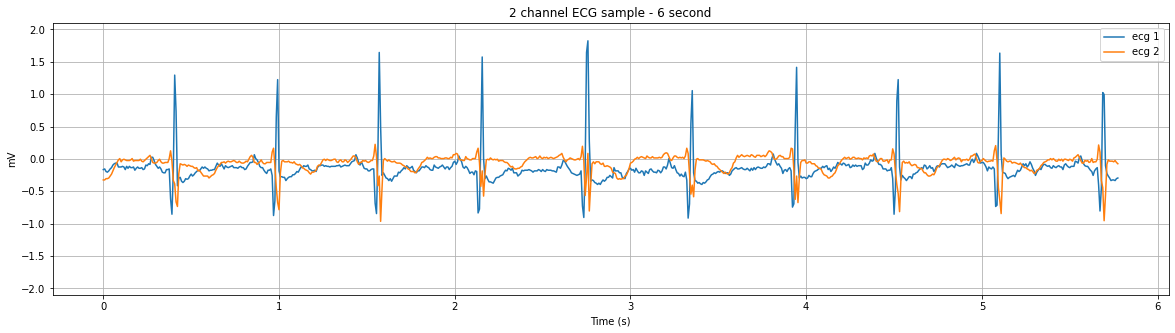

In [11]:
start = df_ecg.index[0].time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=6)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "2 channel ECG sample - 6 second")

In [12]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [13]:
def plot_6s_sample(data, label="2 channel ECG plot - 6s sample", y_label = 'mV'):
    ecg1 = data[0]
    ecg2 = data[1]
    
    times = np.arange(ecg1.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(["ecg1", "ecg2"])
    plt.grid(True)
    plt.show()

In [14]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [15]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [16]:
time_interval = []
if len(df_ecg) > 0:
    intr = [time_result for time_result in perdelta(df_ecg.index[0], df_ecg.index[-1], timedelta(seconds=6))]
    time_interval.append(intr)

In [17]:
ECG_ALS = []
ECG_ALS_label = []

for tm_int in time_interval :
    for time_intv in list(zip(tm_int, tm_int[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        if len(ecg1) > 0 and len(ecg2) > 0:
            ALS1 = ecg1 - baseline_als(ecg1)
            ALS2 = ecg2 - baseline_als(ecg2)

            ECG_ALS.append(np.array([ALS1, ALS2]))
            ECG_ALS_label.append('N')

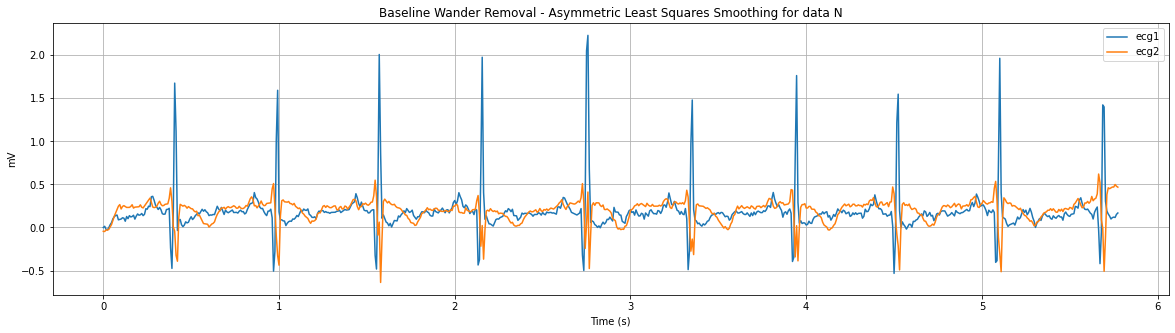

In [18]:
idx = 0
plot_6s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

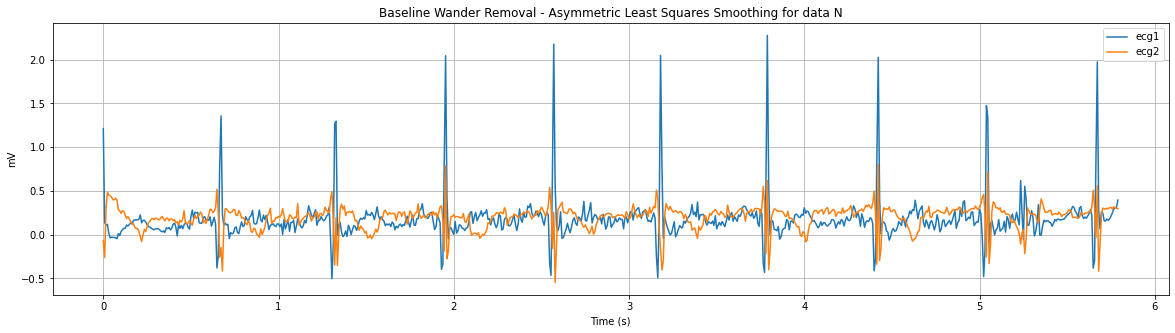

In [19]:
idx = -1
plot_6s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

In [21]:
#scaler = scaler = StandardScaler(with_mean=False, with_std=False) 
#scaler = MinMaxScaler(feature_range=(-1, 1)) # scale to -1 to 1
scaler = MaxAbsScaler()

ECG_ALS_Norm = []

for als in ECG_ALS :
    als1 = np.expand_dims(als[0], 1)
    als2 = np.expand_dims(als[1], 1)
    
    scaler.fit(als1)
    
    als_norm1 = scaler.transform(als1)
    als_norm2 = scaler.transform(als2)
    
    ECG_ALS_Norm.append([als_norm1, als_norm2])

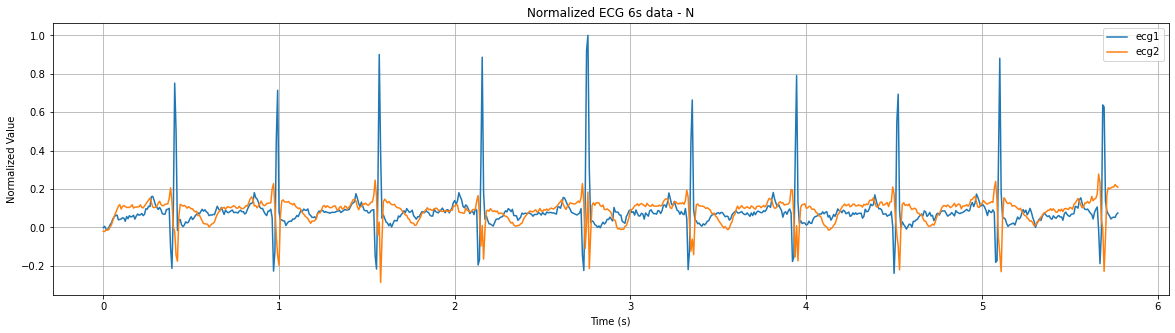

In [22]:
idx = 0
plot_6s_sample(ECG_ALS_Norm[idx], "Normalized ECG 6s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

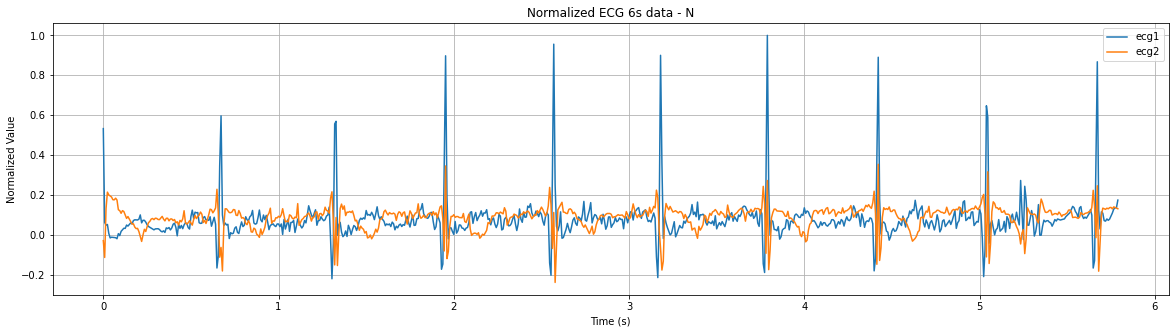

In [23]:
idx = -1
plot_6s_sample(ECG_ALS_Norm[idx], "Normalized ECG 6s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

In [24]:
def upsampling_twice(data):
    # upsampling interpolation
    result = np.zeros(2*len(data)-1)
    result[0::2] = data
    result[1::2] = (data[1:] + data[:-1]) / 2
    return result

In [25]:
new_fs = 250 # Hz 
ECG_ALS_Norm_Up = []
for data in ECG_ALS_Norm :
    data1 = np.array(data[0][:,0])
    data2 = np.array(data[1][:,0])
    data1 = upsampling_twice(data1).reshape(-1, 1) 
    data2 = upsampling_twice(data2).reshape(-1, 1) 
    ECG_ALS_Norm_Up.append([data1, data2])

In [26]:
data = []
pad_size = 4000 # 16s x 250hz
for i in range(len(ECG_ALS_Norm_Up)):
    signal_ch = []
    for ch in [0, 1] :
        signal = np.array(ECG_ALS_Norm_Up[i])[ch, :, 0]
        n = len(signal) if len(signal) <= pad_size else pad_size
        pad = np.zeros(pad_size)
        pad[0:n] = signal[0:n] 
        signal_ch.extend(list(pad))    
    signal_ch.append(ECG_ALS_label[i])
    data.append(signal_ch)

In [27]:
ECG = pd.DataFrame(data)

In [28]:
ECG.head()

,0,1,2,3,4,5,6,7,8,9,...,7991,7992,7993,7994,7995,7996,7997,7998,7999,8000
0,-0.000465,0.002780,0.006025,-0.001942,-0.009909,-0.011149,-0.012388,-0.006900,-0.001412,0.006320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,-0.026300,-0.017410,-0.008520,-0.008620,-0.008720,-0.002073,0.004573,0.008977,0.013380,0.013295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2,0.060225,0.065049,0.069874,0.074698,0.079522,0.071702,0.063881,0.062382,0.060882,0.057274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
3,-0.005656,-0.004864,-0.004073,-0.007631,-0.011190,-0.008222,-0.005254,-0.002285,0.000685,0.005833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
4,0.017692,0.016657,0.015623,0.016755,0.017888,0.021188,0.024488,0.025620,0.026752,0.025717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [29]:
# save Signal Sequence 6s 

ECG.to_csv("dataset/NSRDB_%s_sequence_6s_2_ch.csv" % record, index=False, header=False)